In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from viz_utils import *
from dataloaders import *

In [2]:
RESULT_PATH = "results/"
DATASET = "IMDB-sentences"
MODEL = "JWA"

In [3]:
experiments, meta = load_results(base_dir=RESULT_PATH, dataset=DATASET, model=MODEL)
df_tr, df_agr, df_crt_train, df_crt_test, df_attr = results_to_df(experiments, meta)

In [4]:
meta

{'dataset': 'IMDB-sentences',
 'model': 'JWA',
 'warm_start_size': 20000,
 'batch_size': 32,
 'epochs_per_train': 5,
 'seeds': [1, 2, 3, 4, 5],
 'interpreters': ['deeplift', 'grad-shap', 'int-grad'],
 'tying': 0.5,
 'test_lengths': [100,
  100,
  100,
  100,
  90,
  87,
  87,
  87,
  81,
  81,
  77,
  74,
  74,
  70,
  69,
  66,
  66,
  66,
  65,
  64,
  63,
  59,
  58,
  58,
  57,
  57,
  56,
  56,
  56,
  56,
  56,
  55,
  55,
  55,
  54,
  54,
  54,
  54,
  52,
  52,
  50,
  50,
  49,
  49,
  48,
  48,
  48,
  48,
  48,
  48,
  48,
  48,
  48,
  47,
  47,
  47,
  47,
  46,
  46,
  45,
  45,
  45,
  45,
  44,
  44,
  44,
  44,
  44,
  44,
  43,
  43,
  43,
  43,
  43,
  43,
  42,
  42,
  42,
  41,
  41,
  41,
  41,
  40,
  40,
  40,
  40,
  40,
  40,
  39,
  39,
  39,
  39,
  39,
  39,
  39,
  39,
  39,
  38,
  38,
  38,
  38,
  38,
  38,
  37,
  37,
  37,
  37,
  37,
  37,
  37,
  37,
  37,
  36,
  36,
  36,
  36,
  36,
  36,
  35,
  35,
  35,
  35,
  35,
  35,
  34,
  34,
  34,
  3

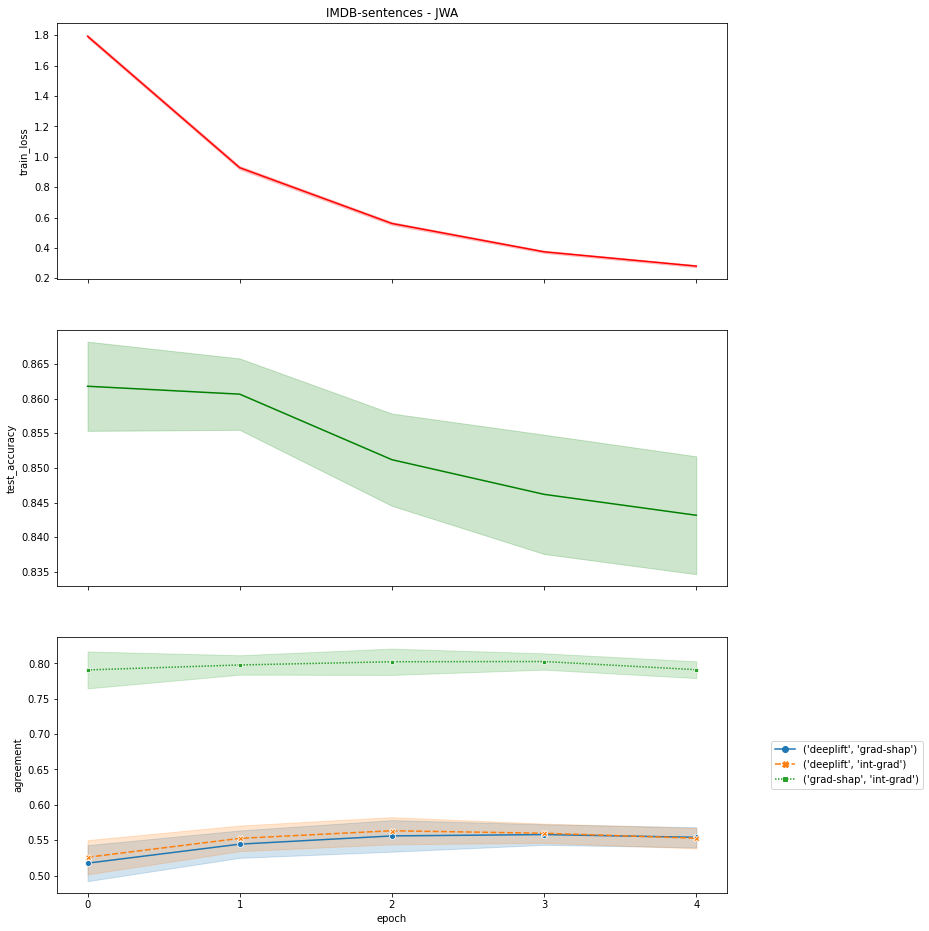

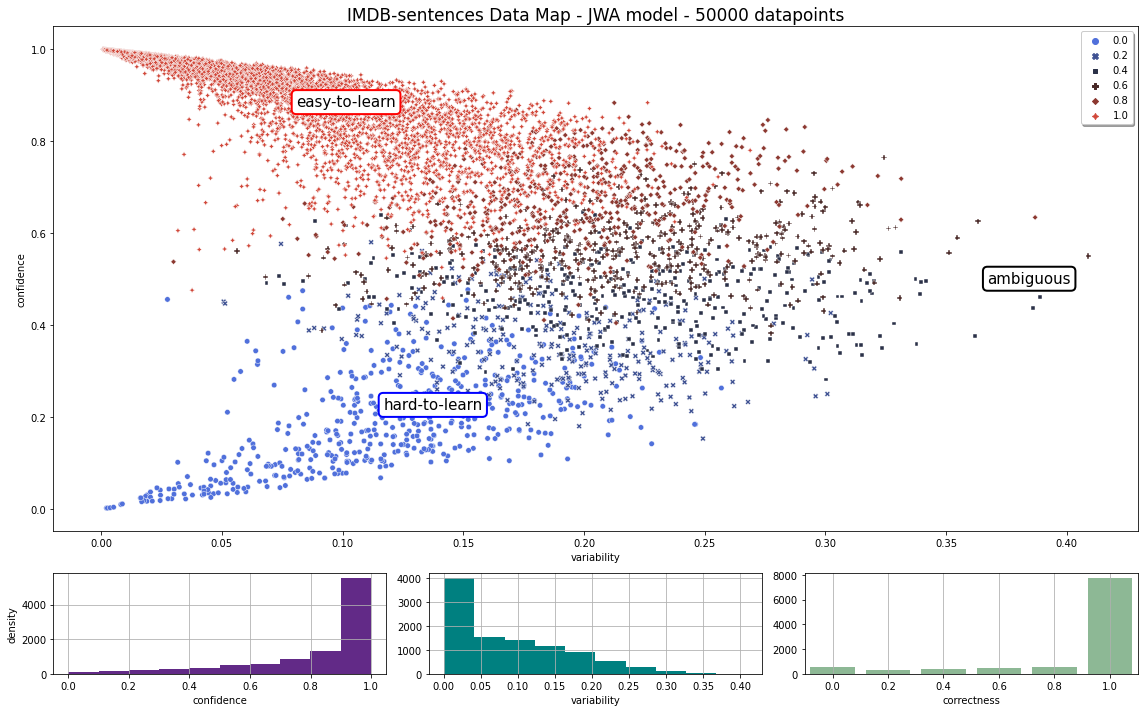

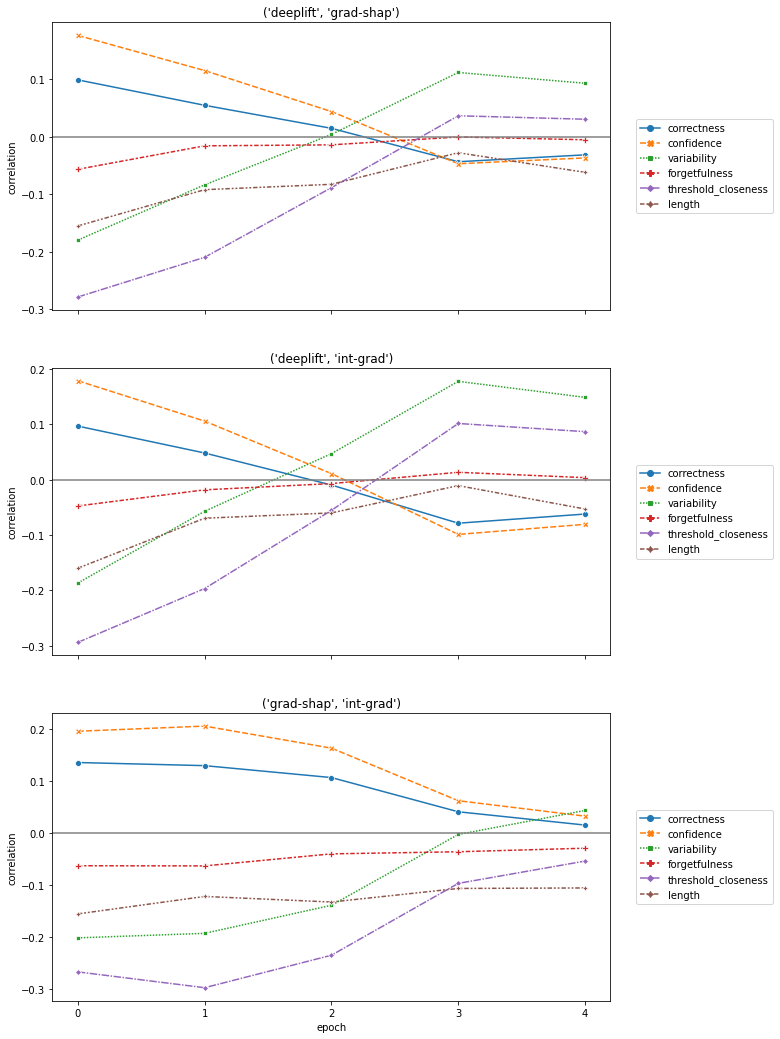

In [5]:
plot_experiment(df_tr, df_agr, meta)
fig = plot_cartography(df_crt_test, meta, hue_metric="correct")
df_corrs = plot_correlations(df_agr, df_crt_test, meta, print_flag=False)

In [6]:
(train, val, test), vocab = load_imdb_sentences(clip=False)
test = test[meta["test_mapping"]]

In [7]:
df_c = df_crt_test[df_crt_test.index.get_level_values("experiment") == 0]
df_a = df_agr[(df_agr.index.get_level_values("experiment") == 0) & (df_agr.index.get_level_values("epoch") == 4)]
df_t = df_attr[(df_attr.index.get_level_values("experiment") == 0) & (df_attr.index.get_level_values("epoch") == 4)]
df_t = df_t.reset_index().set_index("example")
correctness = df_c.correctness.to_numpy()

In [8]:
ip = ("deeplift", "grad-shap")

In [11]:
texts = []
tokens = []
types = []
labels = []

# LABEL_MAP = {"1": "positive", "0": "negative"}
LABEL_MAP = {"positive": "positive", "negative": "negative"}
for i, ex in enumerate(test):
    texts.append(ex.text[0])
    toks = ex.text[1]
    tokens.append(toks)
    labels.append(LABEL_MAP[ex.label[1]])


df_text = pd.DataFrame(
    {
        "text": texts,
        "tokens": tokens,
        "label": labels,
        "correct": df_c.correctness,
        "(deeplift, grad-shap)": df_a.iloc[0].correlation,
        "(deeplift, int-grad)": df_a.iloc[1].correlation,
        "(grad-shap, int-grad)": df_a.iloc[2].correlation,
    }
)
df_text = df_text.reset_index().set_index("example")
df_exs = pd.concat([df_text, df_t], axis=1)

In [12]:
df_exs

,experiment,text,tokens,label,correct,"(deeplift, grad-shap)","(deeplift, int-grad)","(grad-shap, int-grad)",experiment,epoch,deeplift,grad-shap,int-grad
example,,,,,,,,,,,,,
0,0,they all go on board and take their helmets off,"[they, all, go, on, board, and, take, their, h...",negative,0,0.664646,0.641616,0.705455,0,4,"[0.0055019464, 0.09897357, 0.13776949, 0.83296...","[0.0030981917, 0.21888977, 0.25009838, 1.18115...","[0.0023963600642351998, 0.17635472719730988, 0..."
1,0,despite a cast of well known actors trying the...,"[despite, a, cast, of, well, known, actors, tr...",negative,5,0.562828,0.595556,0.876768,0,4,"[0.0011686012, 0.0028574006, 0.0056632515, 0.0...","[0.0029802076, 0.014184357, 0.018708771, 0.007...","[0.002827526656000066, 0.013331745518008527, 0..."
2,0,i felt sorry for the girls mostly who probably...,"[i, felt, sorry, for, the, girls, mostly, who,...",negative,0,0.545051,0.509899,0.696566,0,4,"[0.0090558855, 0.036377467, 0.008008015, 0.025...","[0.008896191, 0.022603374, 0.00046911836, 0.01...","[0.008741755010603553, 0.017501838286534906, 0..."
3,0,elijah wood is magnificent boris leskin is so ...,"[elijah, wood, is, magnificent, boris, leskin,...",positive,5,0.536970,0.483232,0.728081,0,4,"[0.000549773, 0.0052680266, 0.01562576, 0.0203...","[0.003137993, 0.004503239, 0.0042369487, 0.030...","[0.002793467389763551, 0.009968861434373893, 0..."
4,0,actually the q&a did.<br /><br />spoilers below,"[actually, the, q&a, did.<br, /><br, />spoiler...",positive,5,0.655930,0.642946,0.763296,0,4,"[0.0009397756, 0.0038574096, 4.2254454e-05, 0....","[0.0032458445, 0.015453786, 0.005014194, 0.010...","[0.002530721946591323, 0.023690894220576963, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,it makes critters 3 a real redundant sequel yo...,"[it, makes, critters, 3, a, real, redundant, s...",negative,5,0.666667,0.666667,1.000000,0,4,"[0.33204573, 0.01606493, 0.09107258, 1.4097054]","[0.49704036, 0.10582583, 0.8234564, 1.96771]","[0.4766789856873498, 0.14675842393382488, 0.76..."
9996,0,by far better than any other comedy out there,"[by, far, better, than, any, other, comedy, ou...",positive,5,1.000000,1.000000,1.000000,0,4,"[0.024074007, 0.08307408, 6.138836]","[0.048044823, 0.05627273, 7.110558]","[0.0015697839187380491, 0.11523979065071602, 6..."
9997,0,this movie reminded me of another complete was...,"[this, movie, reminded, me, of, another, compl...",negative,5,1.000000,1.000000,1.000000,0,4,"[0.03603677, 0.33349156, 3.6740646]","[0.1670493, 0.3947752, 3.7697875]","[0.06053756337140561, 0.2548620378122918, 4.74..."


In [14]:
ip_str = "(deeplift, grad-shap)"


d1 = df_exs.sort_values(ip_str)[:10]
d2 = df_exs.sort_values(ip_str)[-10:]
d12 = pd.concat([d1, d2])

In [79]:
d12

,experiment,text,tokens,label,correct,"(deeplift, grad-shap)","(deeplift, int-grad)","(grad-shap, int-grad)",experiment,epoch,deeplift,grad-shap,int-grad
example,,,,,,,,,,,,,
2357,0,for a movie shot in 18 days and a budget less ...,"[for, a, movie, shot, in, 18, days, and, a, bu...",positive,0,-0.636364,-0.510390,0.583117,0,4,"[0.11930515, 0.12582052, 0.012868948, 0.050578...","[0.007378778, 0.014972898, 0.033933405, 0.0306...","[0.005362169213544057, 0.0031948322062672722, ..."
3095,0,a ridiculous movie a terrible editing job wors...,"[a, ridiculous, movie, a, terrible, editing, j...",negative,5,-0.573124,-0.131915,0.358119,0,4,"[0.027454961, 0.16497846, 0.07987353, 0.028300...","[0.017781857, 0.09627481, 0.06844036, 0.052322...","[0.014461617471246174, 0.0806037129218154, 0.0..."
3119,0,i am a fan of slasher movies especially of scr...,"[i, am, a, fan, of, slasher, movies, especiall...",negative,1,-0.566049,-0.281481,0.280864,0,4,"[0.48210186, 0.20441595, 0.32423544, 0.4079941...","[0.00093403645, 0.0052555394, 0.010533371, 0.0...","[0.038684989381646516, 0.012840091734637652, 0..."
2234,0,this documentary was very amateurish it could ...,"[this, documentary, was, very, amateurish, it,...",negative,5,-0.557833,-0.335196,0.647570,0,4,"[0.08899902, 0.225413, 0.03840183, 0.21796638,...","[0.0037671928, 0.012331829, 0.021153167, 0.000...","[0.002870571634592597, 0.03129833384204161, 0...."
3171,0,i was hoping this would be a good weekly vehic...,"[i, was, hoping, this, would, be, a, good, wee...",negative,5,-0.556078,-0.375686,0.568627,0,4,"[0.29451567, 0.058275335, 0.16025594, 0.146287...","[0.004009923, 0.038803622, 0.019618398, 0.0329...","[0.02833573532425663, 0.04447750923627472, 0.0..."
631,0,i have just watched this movie on dvd late thi...,"[i, have, just, watched, this, movie, on, dvd,...",negative,2,-0.550877,-0.230816,0.405339,0,4,"[0.42625025, 0.02049753, 0.120158285, 0.253548...","[0.0003380659, 0.009652546, 0.019352037, 0.003...","[0.0316605532210021, 0.012209639711346438, 0.0..."
4358,0,nicely done evil little comedy pitting the fbi...,"[nicely, done, evil, little, comedy, pitting, ...",positive,5,-0.542393,0.094077,-0.096400,0,4,"[0.2337763, 0.033122964, 0.14002565, 0.0221733...","[0.0045958953, 0.0471487, 0.069071844, 0.06195...","[0.028893226061855487, 0.050764956832572886, 0..."
1571,0,this is a good plot concept so why o why is it...,"[this, is, a, good, plot, concept, so, why, o,...",negative,5,-0.535686,-0.410196,0.786667,0,4,"[0.15104724, 0.29181862, 0.19293046, 0.3345067...","[0.0071666157, 0.0009410549, 0.01592685, 0.002...","[0.010191551812202082, 0.03141470760352636, 0...."
4342,0,if you want to see a film with no guns blood s...,"[if, you, want, to, see, a, film, with, no, gu...",positive,4,-0.532240,0.098361,0.174863,0,4,"[0.044026487, 0.12522711, 0.066384465, 0.01201...","[0.016335689, 0.010213905, 0.013880571, 0.0212...","[0.032672684565676284, 0.003520441402711679, 0..."


In [15]:
import matplotlib
from spacy import displacy
from sklearn.preprocessing import MinMaxScaler as MMS
from sklearn.preprocessing import normalize
from scipy.stats import kendalltau
from scipy.stats import rankdata


TPL_TOK = """
<mark class="entity" style="background: {bg}; padding: 0.45em 0.6em; margin: 0 0.05em; line-height: 1; border-radius: 0.01em; box-decoration-break: clone; -webkit-box-decoration-break: clone">
    {text}
</mark>
"""

cmap = sns.color_palette("coolwarm", as_cmap=True)


def example_viz(example, interpreter="deeplift"):
    mms = MMS((0, 256))
    colors = (
        mms.fit_transform(example[interpreter].reshape(-1, 1)).ravel().astype(np.int32)
    )
    colors = {
        str(i): matplotlib.colors.to_hex(cmap(c), keep_alpha=True)
        for i, c in enumerate(colors)
    }

    ents = []
    ii = 0
    for itok in range(len(example.tokens)):
        ff = ii + len(example.tokens[itok])
        ent = {
            "start": ii,
            "end": ff,
            "label": str(itok),
        }
        ents.append(ent)
        ii = ff

    to_render = {
        "text": "".join(example.tokens),
        "ents": ents,
    }

    html = displacy.render(
        to_render,
        style="ent",
        manual=True,
        jupyter=True,
        options={"colors": colors, "template": TPL_TOK},
    )

    return html


def norm(v):
    return normalize(v.reshape(-1, 1)).ravel()


def example_agreement_viz(example, interpret_pair):
    mms = MMS((0, 256))
    w1 = example[interpret_pair[0]]
    w2 = example[interpret_pair[1]]
    r1 = rankdata(-w1, method="ordinal")
    r2 = rankdata(-w2, method="ordinal")
    tau, p_value = kendalltau(w1, w2)
    print(f"Agreement {interpret_pair}: [Kendall's tau = {tau}] [p-val = {p_value}]")
    agreement = w1.size - np.fabs(r1 - r2)
    colors = mms.fit_transform(agreement.reshape(-1, 1)).ravel().astype(np.int32)
    colors = {
        str(i): matplotlib.colors.to_hex(cmap(c), keep_alpha=True)
        for i, c in enumerate(colors)
    }

    ents = []
    ii = 0
    for itok in range(len(example.tokens)):
        ff = ii + len(example.tokens[itok])
        ent = {
            "start": ii,
            "end": ff,
            "label": str(itok),
        }
        ents.append(ent)
        ii = ff

    to_render = {
        "text": "".join(example.tokens),
        "ents": ents,
    }

    html = displacy.render(
        to_render,
        style="ent",
        manual=True,
        jupyter=True,
        options={"colors": colors, "template": TPL_TOK},
    )

    return html


ip = ("deeplift", "grad-shap")


for ind, i in enumerate(range(len(d12))):
    ex = d12.iloc[i]
    print(f"Example no. {ind}")
    print("-" * 100)
    print(ex.text)
    print()
    print(f"Sentiment: {ex.label}")
    print(f"Cartography: {ex.correct}")
    print("-" * 100)
    for interpreter in ["deeplift", "grad-shap"]:
        print(f"Interpreter: {interpreter}")
        example_viz(ex, interpreter=interpreter)
        print("-" * 100)
    
#     print(f"Aggrement between {ip}")
    example_agreement_viz(d12.iloc[i], ip)

Example no. 0
----------------------------------------------------------------------------------------------------
ed is upset by some of the clips working on them up at this house all by himself that the boss has decided to relocate him to for no apparent reason

Sentiment: negative
Cartography: 3
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = -1.0] [p-val = 0.3333333333333333]


Example no. 1
----------------------------------------------------------------------------------------------------
does it work

Sentiment: positive
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = -1.0] [p-val = 0.08333333333333333]


Example no. 2
----------------------------------------------------------------------------------------------------
i carry those memories for years it was so much fun

Sentiment: positive
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = -0.6666666666666669] [p-val = 0.3333333333333333]


Example no. 3
----------------------------------------------------------------------------------------------------
the plot is n't clear on this and they inter splice these scenes where he is seeing a shrink about his problem.<br /><br />the lead girl gets pregnant while still a virgin with an incredibly creepy scene of her father giving her a gynecological exam to prove her hymen is still intact eeeewwwwww

Sentiment: negative
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = -0.6] [p-val = 0.23333333333333334]


Example no. 4
----------------------------------------------------------------------------------------------------
she loves him so much

Sentiment: positive
Cartography: 0
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = -0.6] [p-val = 0.23333333333333334]


Example no. 5
----------------------------------------------------------------------------------------------------
extremely convincing war scenes and so impressive acting most of the scenes look like isolated theater pieces

Sentiment: positive
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = -0.4666666666666666] [p-val = 0.07255015432098766]


Example no. 6
----------------------------------------------------------------------------------------------------
the film then has to rely on its talents and they are all sure fire delivering a new understanding of a subject that 's so familiar

Sentiment: positive
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = -0.4285714285714286] [p-val = 0.2388888888888889]


Example no. 7
----------------------------------------------------------------------------------------------------
there 's even a nice little cameo role for the apparently famous czech musician and actor and kevin kline lookalike oldrich kaiser who plays on the piano the title theme song dark blue sky

Sentiment: positive
Cartography: 2
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = -0.3571428571428571] [p-val = 0.27509920634920637]


Example no. 8
----------------------------------------------------------------------------------------------------
now owen hangs around with bob and alicia

Sentiment: positive
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = -0.33333333333333337] [p-val = 1.0]


Example no. 9
----------------------------------------------------------------------------------------------------
i have heard this film was shot in about 12 days and i suppose instead of starting back to one they just restarted without stopping and edited the scene together

Sentiment: negative
Cartography: 0
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = -0.33333333333333337] [p-val = 1.0]


Example no. 10
----------------------------------------------------------------------------------------------------
a housekeeper 's husband is killed when he is hit by a car while on a bicycle

Sentiment: positive
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 1.0] [p-val = 0.08333333333333333]


Example no. 11
----------------------------------------------------------------------------------------------------
the idea that anyone could of concocted such a trite cliché yet indeliberately comical movie is shocking

Sentiment: negative
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 1.0] [p-val = 0.08333333333333333]


Example no. 12
----------------------------------------------------------------------------------------------------
it is a pitiful looking film whatever poor topsy had done it was a poor beast not a machiavellian murderer

Sentiment: negative
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 1.0] [p-val = 0.08333333333333333]


Example no. 13
----------------------------------------------------------------------------------------------------
and she is just one of many artist interviewed and recorded speaking of their experiences of performing in istanbul

Sentiment: positive
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 1.0] [p-val = 0.08333333333333333]


Example no. 14
----------------------------------------------------------------------------------------------------
so if you liked evil dead 2 or any of the other movies i mentioned above you got ta rent and watch it with a freind and when your done try brain dead because i hear it is similiar to this masterpiece

Sentiment: positive
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 1.0] [p-val = 0.08333333333333333]


Example no. 15
----------------------------------------------------------------------------------------------------
instead we get a clumsy ex police dog who 's even dumber than cad

Sentiment: negative
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 1.0] [p-val = 0.08333333333333333]


Example no. 16
----------------------------------------------------------------------------------------------------
oh and another girl is stabbed with a pair of weenie tongs.<br /><br />look i get what 's coming to me when i sit down to watch a killer snowman movie such a ridiculous supernatural slasher will either tickle your funnybone('oh it 's such a wonderfully cheesy horror movie!')or have you pondering why the hell you 're wasting time with such nonsense

Sentiment: negative
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 1.0] [p-val = 0.08333333333333333]


Example no. 17
----------------------------------------------------------------------------------------------------
we learn next to nothing about friendship and daniel auteuil may be a fine actor but not one minute do we believe he could be the cut throat egoist the script depends on him to be

Sentiment: negative
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 1.0] [p-val = 0.08333333333333333]


Example no. 18
----------------------------------------------------------------------------------------------------
most disappointing of all was john malkovich as kurtz

Sentiment: negative
Cartography: 1
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 1.0] [p-val = 0.08333333333333333]


Example no. 19
----------------------------------------------------------------------------------------------------
in a very subpar year for movies nurse betty ranks as one of the more pleasant surprises of 2000

Sentiment: positive
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 1.0] [p-val = 0.3333333333333333]
